In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [57]:
train = pd.read_csv('/Users/lamprosganias/Desktop/Cybersecurity and Data Science/Β Εξάμηνο/Time-Series Analytics and Forecasting (CDS214)/Datasets/Daily-train.csv')
test = pd.read_csv('/Users/lamprosganias/Desktop/Cybersecurity and Data Science/Β Εξάμηνο/Time-Series Analytics and Forecasting (CDS214)/Datasets/Daily-test.csv')

__Selecting the Time Series Data for Our Predictions__

In [58]:
train = train.iloc[0]
test = test.iloc[0]

In [59]:
train = train.dropna()  
train = train.to_frame()
test = test.dropna()  
test = test.to_frame()

In [60]:
train

,0
V1,D1
V2,1017.1
V3,1019.3
V4,1017.0
V5,1019.2
...,...
V1003,2015.6
V1004,2009.7
V1005,2022.1
V1006,2031.6


In [61]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [62]:
header_row_train = train.iloc[0]
header_row_test = test.iloc[0]
train = pd.DataFrame(train.values[1:], columns=header_row_train)
test = pd.DataFrame(test.values[1:], columns=header_row_test)
data = pd.concat([train, test], axis=0)
data = data.reset_index(drop=True)
data = data.drop(columns=['V1'])
data


,D1
0,1017.1
1,1019.3
2,1017.0
3,1019.2
4,1018.7
...,...
1015,2066.4
1016,2067.4
1017,2071.4
1018,2083.8


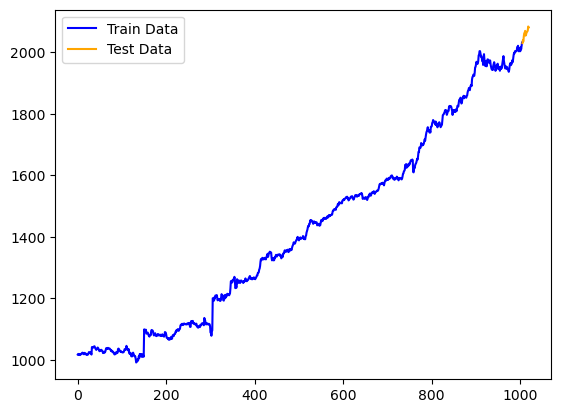

In [63]:
plt.plot(data[0:1005], color='blue', label='Train Data')
plt.plot(data[1005:], color='orange', label='Test Data')
plt.legend()
plt.show()

__We keep only the percentage deffernce of our sequencing data, trying to do the data stationary__

In [64]:
returns = data['D1'].pct_change()

__As we can see we succeed to make the data stationary__

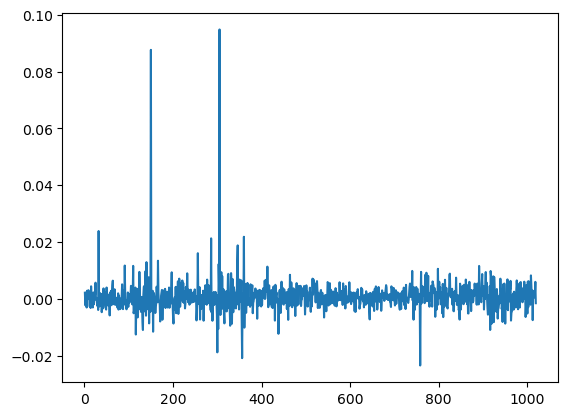

In [65]:
plt.plot(returns)

In [66]:
# Flatten this matrix down.
npa = returns.values[:].reshape(-1,1)
print(len(npa))

1020


__Next we scale the data fitting only the tain data, excluding the lat 15 of train data and test data__

In [67]:
# Let's scale the data -- this helps avoid the exploding gradient issue
scale = MinMaxScaler(feature_range=(0,1))
scale.fit(npa[:988])
npa = scale.transform(npa)
print(len(npa))

1020


In [68]:
npa[0] = 0

In [69]:
train_npa = npa[0:len(train)-16]
len(train_npa)

990

In [70]:
test_npa = npa[len(train):len(data)+1]
len(test_npa)

14

In [71]:
npa.shape[0]

1020

__We create the Sequence for the SimpleRNN model, setting the time windows in 15__

In [72]:
samples = 15  # Past samples
steps = 1  # Future steps
X = []  
Y = []  

for i in range(train_npa.shape[0] - samples):
    X.append(train_npa[i:i+samples]) 
    Y.append(train_npa[i+samples][0])  

print('Training Data: Length is', len(X[0]), ':', X[0])
print('Testing Data:',Y[0])

Training Data: Length is 15 : [[0.        ]
 [0.21657838]
 [0.17922945]
 [0.21658018]
 [0.19415283]
 [0.17258152]
 [0.22243022]
 [0.19663924]
 [0.19912865]
 [0.22402353]
 [0.21070844]
 [0.20077704]
 [0.1751747 ]
 [0.20575186]
 [0.17099471]]
Testing Data: 0.23565218710243063


__We reshape the data so that the inputs will be acceptable to the model__


In [73]:
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)

Dimensions of X (975, 15, 1) Dimensions of Y (975,)


In [74]:
npa[1006]

array([0.23785365])

In [75]:
threshold = npa[991:1006]
print('Threshold is', threshold)

Threshold is [[0.20420647]
 [0.19914211]
 [0.24931766]
 [0.19871785]
 [0.21757702]
 [0.14435879]
 [0.175995  ]
 [0.23922679]
 [0.2033376 ]
 [0.15465463]
 [0.24976241]
 [0.17356121]
 [0.25044211]
 [0.23800231]
 [0.19039515]]


# RNN

__We build our model__

In [76]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


model = keras.Sequential()
model.add(layers.SimpleRNN(16,
                           activation = 'tanh',
                           use_bias=True,
                           input_shape=(X.shape[1], X.shape[2])))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(1))
model.compile(loss='mse', optimizer = 'sgd')
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 16)                288       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________


__Next we fit our training data with our model__

In [77]:
history = model.fit(X,
                    Y,
                    shuffle = False, 
                    epochs=500,
                    batch_size=128,
                    validation_split=0.1,
                    verbose=1, 
                    ) 

Epoch 1/500


7/7 [==============================] - 1s 28ms/step - loss: 0.1376 - val_loss: 0.0097
Epoch 2/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0156 - val_loss: 0.0064
Epoch 3/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0129 - val_loss: 0.0065
Epoch 4/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0128 - val_loss: 0.0064
Epoch 5/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0130 - val_loss: 0.0061
Epoch 6/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0127 - val_loss: 0.0061
Epoch 7/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0116 - val_loss: 0.0060
Epoch 8/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0120 - val_loss: 0.0060
Epoch 9/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0116 - val_loss: 0.0060
Epoch 10/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0110 - val_loss: 0.0059
Epoch 11/500
7/7 [======================

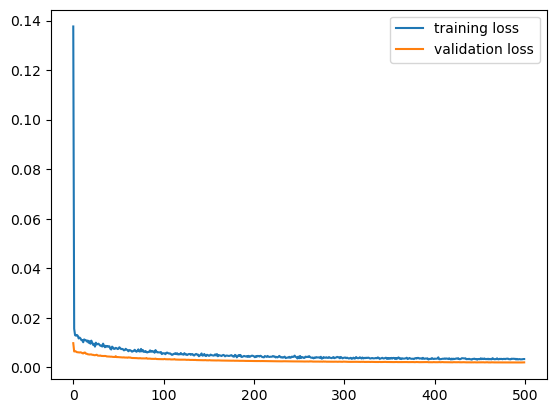

In [78]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label ='validation loss')
plt.legend()

In [79]:
true_Y = npa[1006:1020]
pred_Y = []
print('Number of Forecasts to do: ',len(true_Y))

Number of Forecasts to do:  14


__For each prediction we make, we add the value at the end of the 15 data__

In [80]:
for i in range(1006,1020):
    p = model.predict(threshold.reshape(1,X.shape[1],1))[0,0]
    threshold = np.roll(threshold, -1)  
    threshold[-1] = p  
    pred_Y.append(p)
    print(p)

1/1 [==============================] - 0s 97ms/step
0.21063583
1/1 [==============================] - 0s 15ms/step
0.19881292
1/1 [==============================] - 0s 14ms/step
0.24478841
1/1 [==============================] - 0s 14ms/step
0.19287929
1/1 [==============================] - 0s 14ms/step
0.196771
1/1 [==============================] - 0s 14ms/step
0.20470288
1/1 [==============================] - 0s 14ms/step
0.20397377
1/1 [==============================] - 0s 14ms/step
0.21145254
1/1 [==============================] - 0s 14ms/step
0.20337008
1/1 [==============================] - 0s 14ms/step
0.20094766
1/1 [==============================] - 0s 13ms/step
0.21016286
1/1 [==============================] - 0s 13ms/step
0.20789784
1/1 [==============================] - 0s 13ms/step
0.22315997
1/1 [==============================] - 0s 14ms/step
0.20828217


__As we can see the model seems to predict good some movements, but it misses some also__

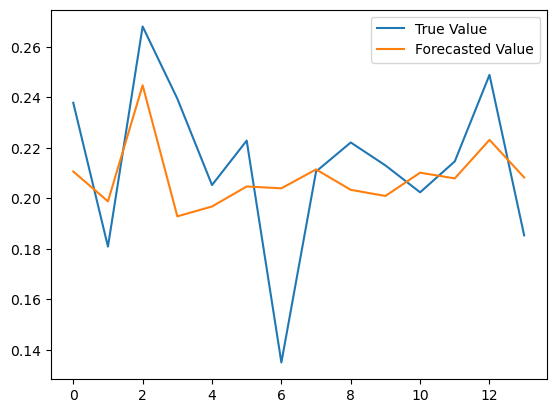

In [81]:
plt.plot(true_Y, label = 'True Value')
plt.plot(pred_Y, label = 'Forecasted Value')
plt.legend()

__We inverse our scaled data__

In [82]:
true_Y_inversed = scale.inverse_transform(np.array(true_Y).reshape(-1, 1))
pred_Y_inversed = scale.inverse_transform(np.array(pred_Y).reshape(-1, 1))

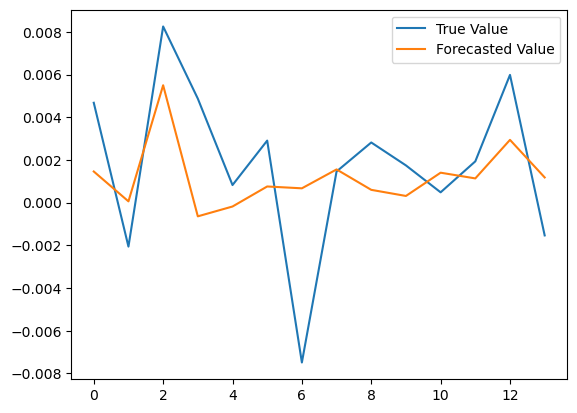

In [83]:
plt.plot(true_Y_inversed, label = 'True Value')
plt.plot(pred_Y_inversed, label = 'Forecasted Value')
plt.legend()

In [84]:
last_value = train['D1'].iloc[1005]
S = []
S.append(last_value + (last_value * pred_Y_inversed[0]))
for index in range(1, len(true_Y)):
    S.append(S[index - 1] + (S[index - 1] * pred_Y_inversed[index]))


In [114]:
S_df = pd.DataFrame(S, columns = ['D1_RNN'])
S_df

,D1_RNN
0,2032.662964
1,2032.786621
2,2043.969116
3,2042.658325
4,2042.289062
5,2043.836670
6,2045.209106
7,2048.392334
8,2049.621582
9,2050.263916


__After the transformation to original values, we can see that the prediction are fairly close__

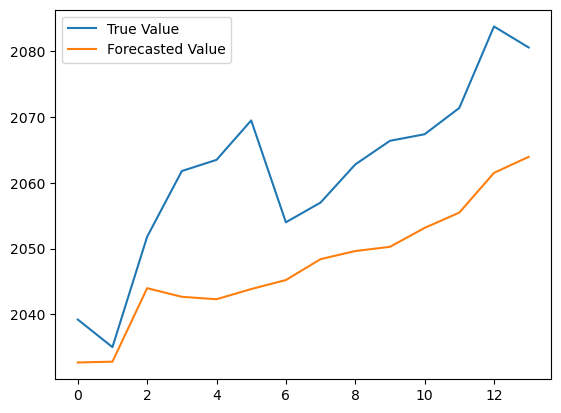

In [86]:
plt.plot(test['D1'], label = 'True Value')
plt.plot(S, label = 'Forecasted Value')
plt.legend()

In [87]:
dfS = pd.DataFrame(S, columns=['D1'])

In [88]:
start_index = 1006
end_index = 1019
new_index = range(start_index, end_index + 1)

dfS.set_index(pd.Index(new_index), inplace=True)

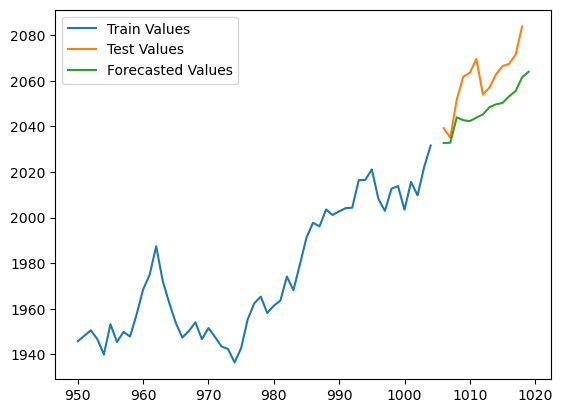

In [89]:
plt.plot(data[950:1005], label = 'Train Values')
plt.plot(data[1006:1019], label = 'Test Values ')
plt.plot(dfS, label = 'Forecasted Values')
plt.legend()

In [90]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Calculate mean squared error (MSE)
mse = mean_squared_error(test['D1'], S)

# Calculate mean absolute error (MAE)
mae = mean_absolute_error(test['D1'], S)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 242.8242167815161
Mean Absolute Error (MAE): 14.172558593750068


# MLP

__Next we create a MLP model to compare them with simpleRNN, following the same procedure__

In [91]:
# Define the model architecture
model1 = keras.Sequential()
model1.add(layers.Dense(128, activation='tanh', input_shape=(X.shape[1], X.shape[2])))
model1.add(layers.Dense(32, activation='relu'))
model1.add(layers.Dense(1, activation='linear'))

# Compile the model
model1.compile(optimizer='adam', loss='mse')

In [92]:
history1 = model1.fit(X, Y, shuffle = False, 
        epochs=300,
        batch_size=64,
        validation_split=0.1,
        verbose=1,
        )


Epoch 1/300
14/14 [==============================] - 0s 10ms/step - loss: 0.0121 - val_loss: 0.0038
Epoch 2/300
14/14 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 0.0019
Epoch 3/300
14/14 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 4/300
14/14 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 5/300
14/14 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 6/300
14/14 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 7/300
14/14 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 8/300
14/14 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 9/300
14/14 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 10/300
14/14 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 11

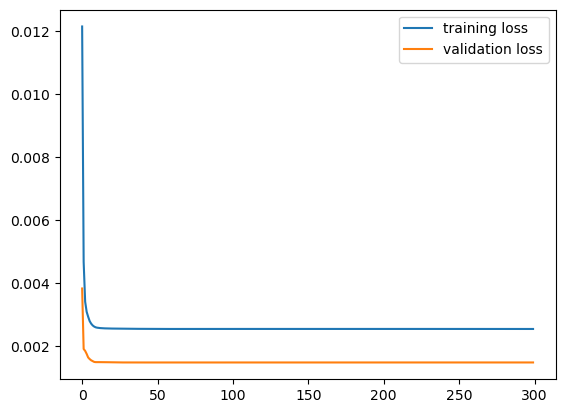

In [93]:
plt.plot(history1.history['loss'], label = 'training loss')
plt.plot(history1.history['val_loss'], label ='validation loss')
plt.legend()


In [94]:
true_Y_MLP = npa[1006:1020]
pred_Y_MLP= []
print('Number of Forecasts to do: ',len(true_Y_MLP))

Number of Forecasts to do:  14


In [95]:
for i in range(1006,1020):
    p = model1.predict(threshold.reshape(1,X.shape[1],1))[0,0]
    threshold = np.roll(threshold, -1)  # 
    threshold[-1] = p  
    pred_Y_MLP.append(p)
    print(p)

1/1 [==============================] - 0s 83ms/step
[0.20293272]
1/1 [==============================] - 0s 15ms/step
[0.20305896]
1/1 [==============================] - 0s 15ms/step
[0.20298535]
1/1 [==============================] - 0s 14ms/step
[0.20326936]
1/1 [==============================] - 0s 14ms/step
[0.2029483]
1/1 [==============================] - 0s 15ms/step
[0.20297259]
1/1 [==============================] - 0s 14ms/step
[0.2030221]
1/1 [==============================] - 0s 15ms/step
[0.20301753]
1/1 [==============================] - 0s 14ms/step
[0.20306402]
1/1 [==============================] - 0s 14ms/step
[0.20301378]
1/1 [==============================] - 0s 14ms/step
[0.20299867]
1/1 [==============================] - 0s 14ms/step
[0.20305601]
1/1 [==============================] - 0s 14ms/step
[0.20304194]
1/1 [==============================] - 0s 14ms/step
[0.20313647]


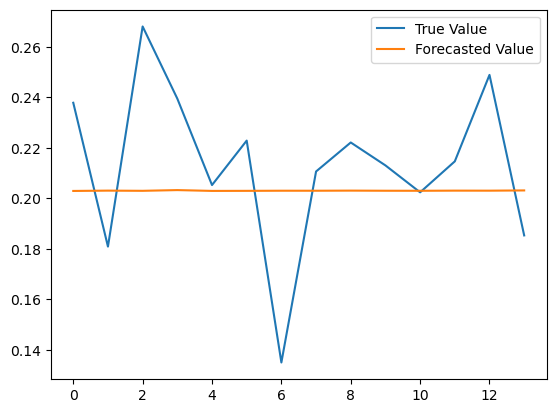

In [96]:
plt.plot(true_Y_MLP, label = 'True Value')
plt.plot(pred_Y_MLP, label = 'Forecasted Value')
plt.legend()

In [97]:
true_Y_inversed_MLP = scale.inverse_transform(np.array(true_Y_MLP).reshape(-1, 1))
pred_Y_inversed_MLP = scale.inverse_transform(np.array(pred_Y_MLP).reshape(-1, 1))

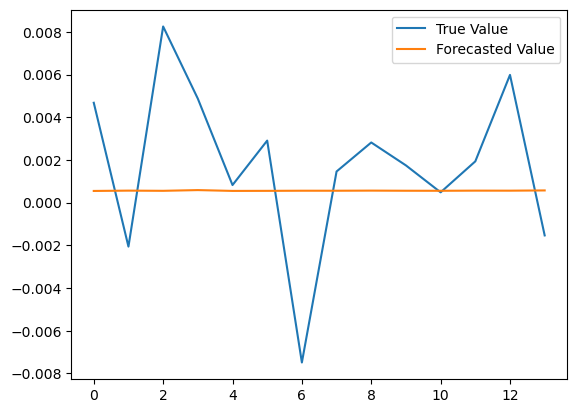

In [98]:
plt.plot(true_Y_inversed_MLP, label = 'True Value')
plt.plot(pred_Y_inversed_MLP, label = 'Forecasted Value')
plt.legend()

In [99]:
last_value = train['D1'].iloc[1005]
S_MLP = []
S_MLP.append(last_value + (last_value * pred_Y_inversed_MLP[0]))
for index in range(1, len(true_Y_inversed_MLP)):
    S_MLP.append(S_MLP[index - 1] + (S_MLP[index - 1] * pred_Y_inversed_MLP[index]))


In [100]:
dfS_MLP = pd.DataFrame(S_MLP, columns=['D1'])

In [101]:
start_index = 1006
end_index = 1019
new_index = range(start_index, end_index + 1)

dfS_MLP.set_index(pd.Index(new_index), inplace=True)

In [102]:
dfS_MLP.set_index(pd.Index(new_index), inplace=True)

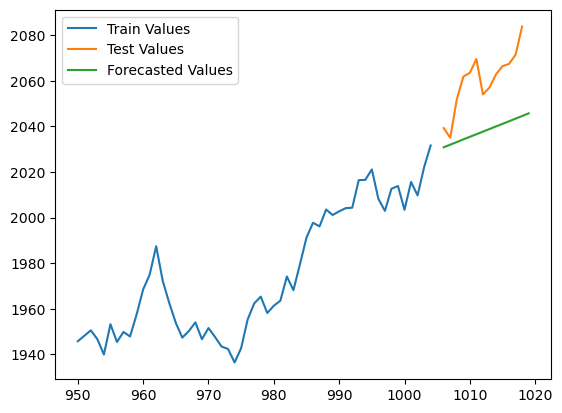

In [103]:
plt.plot(data[950:1005], label = 'Train Values')
plt.plot(data[1006:1019], label = 'Test Values ')
plt.plot(dfS_MLP, label = 'Forecasted Values')
plt.legend()

In [113]:
S_MLP_df = pd.DataFrame(S_MLP, columns = ['D1_MLP'])
S_MLP_df

,D1_MLP
0,2030.812866
1,2031.956787
2,2033.083618
3,2034.279419
4,2035.398682
5,2036.524414
6,2037.662598
7,2038.800415
8,2039.950073
9,2041.088257


In [115]:
result_df = pd.concat([data[1006:].reset_index(drop=True), S_df, S_MLP_df], axis=1)
result_df.columns = ['D1_test', 'D1_RNN', 'D1_MLP']

In [116]:
result_df

,D1_test,D1_RNN,D1_MLP
0,2039.2,2032.662964,2030.812866
1,2035.0,2032.786621,2031.956787
2,2051.8,2043.969116,2033.083618
3,2061.8,2042.658325,2034.279419
4,2063.5,2042.289062,2035.398682
5,2069.5,2043.836670,2036.524414
6,2054.0,2045.209106,2037.662598
7,2057.0,2048.392334,2038.800415
8,2062.8,2049.621582,2039.950073
9,2066.4,2050.263916,2041.088257
